# Plotting the position of any obeject in the local sky

In [1]:
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import orbital

# Load SPICE Kernels

In [2]:
mk_file = '../SPICE_kernels/mk/metakernel_mac.txt'
spice.furnsh(mk_file)

## Astronomical Parameters for Earth and the Object

In [3]:
object_name = 'MOON'
r_earth = spice.bodvrd('EARTH', 'RADII', 3)[1] # [km]
re = r_earth[0]
rp = r_earth[2]
f = (re -rp)/re
print('Earth radii:', r_earth)
r_object = spice.bodvrd(object_name, 'RADII', 3)[1] # [km]
re_object = r_object[0]
AU = 1.4959787e8 # [km]
day = 86400 # [s]
# moon_sma = 384399 # [km]

Earth radii: [6378.1366 6378.1366 6356.7519]


## Set the reference date and time for observation (UTC)

In [4]:
date_utc = '2024 March 17, 21:03:00 UTC' 
date_et = spice.str2et(date_utc)
print('ET: ', date_et)
num_times = 100
num_days = 1
num_hours = 3
et_array = np.linspace(date_et, date_et+num_hours*3600, num_times)

ET:  763981449.1855887


## Set the geodetic coordinates of the observer location

In [5]:
# Get observation location in ECEF frame:
lat_obs = 39.5*(np.pi/180) # [rad]
lon_obs = -104.7*(np.pi/180) # [rad]
alt_obs = 1828e-3 # [km]

## Object States in Earth Centered Intertial Frame and ECEF

In [6]:
object_states = spice.spkpos(object_name, et_array, 'ECLIPJ2000', 'none', 'EARTH')
object_pos = object_states[0] # intertial
# Convert positions to ECEF frame:
object_pos_ecef = np.empty((object_pos.shape[0],object_pos.shape[1]))
for i in range(object_pos.shape[0]):
    ECI2ECEF = spice.pxform('ECLIPJ2000', 'IAU_EARTH', et_array[i])
    object_pos_ecef[i,:] = spice.mxvg(ECI2ECEF, object_pos[i,:])

## Map Position to ENU Frame of Observer

In [7]:
# moon_pos_ecef_test = object_pos_ecef[1,:]

obs_pos_ecef = spice.georec(lon_obs, lat_obs, alt_obs, re, f)


## Object Position in ENU Frame

In [8]:
# los_ecef = moon_pos_ecef_test - obs_pos_ecef # line of site vector from obs to moon
los_ecef = np.empty((object_pos_ecef.shape[0], object_pos_ecef.shape[1]))
print(object_pos_ecef.shape[0])
az = np.empty((object_pos_ecef.shape[0],1))
el = np.empty((object_pos_ecef.shape[0],1))
for i in range(object_pos_ecef.shape[0]):
    los_ecef = object_pos_ecef[i,:] - obs_pos_ecef
    pos_enu = orbital.C_ecef2enu(lat_obs, lon_obs)@los_ecef
    az[i], el[i] = orbital.AZEL(pos_enu)


100
Object position in ENU: [154605.76696243 -52176.96094194 350700.66344334]


## Sky Plot

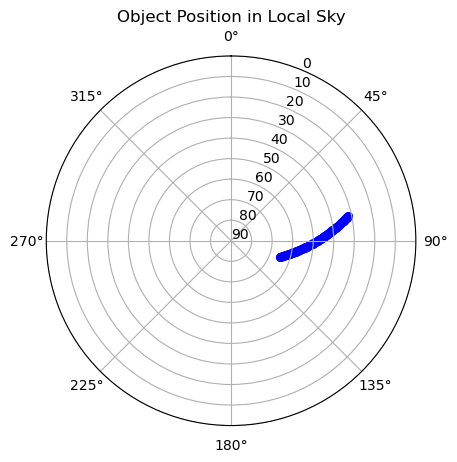

In [9]:
fig = plt.figure()
ax = fig.add_subplot(polar=True)
ax.scatter(az, el*180/np.pi, c='blue', s=30)
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_rlim(bottom=90, top=0)
plt.title('Object Position in Local Sky')
plt.show()